In [1]:
import sys
sys.path.append('../')

import numpy as np
#from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
#from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d, relu
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Confirming that most energy lies within the first 3 DCT coeficients

In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        conv_layers.append(l)


(13, 3, 3, 1, 1)
(13, 1, 1, 256, 256)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator


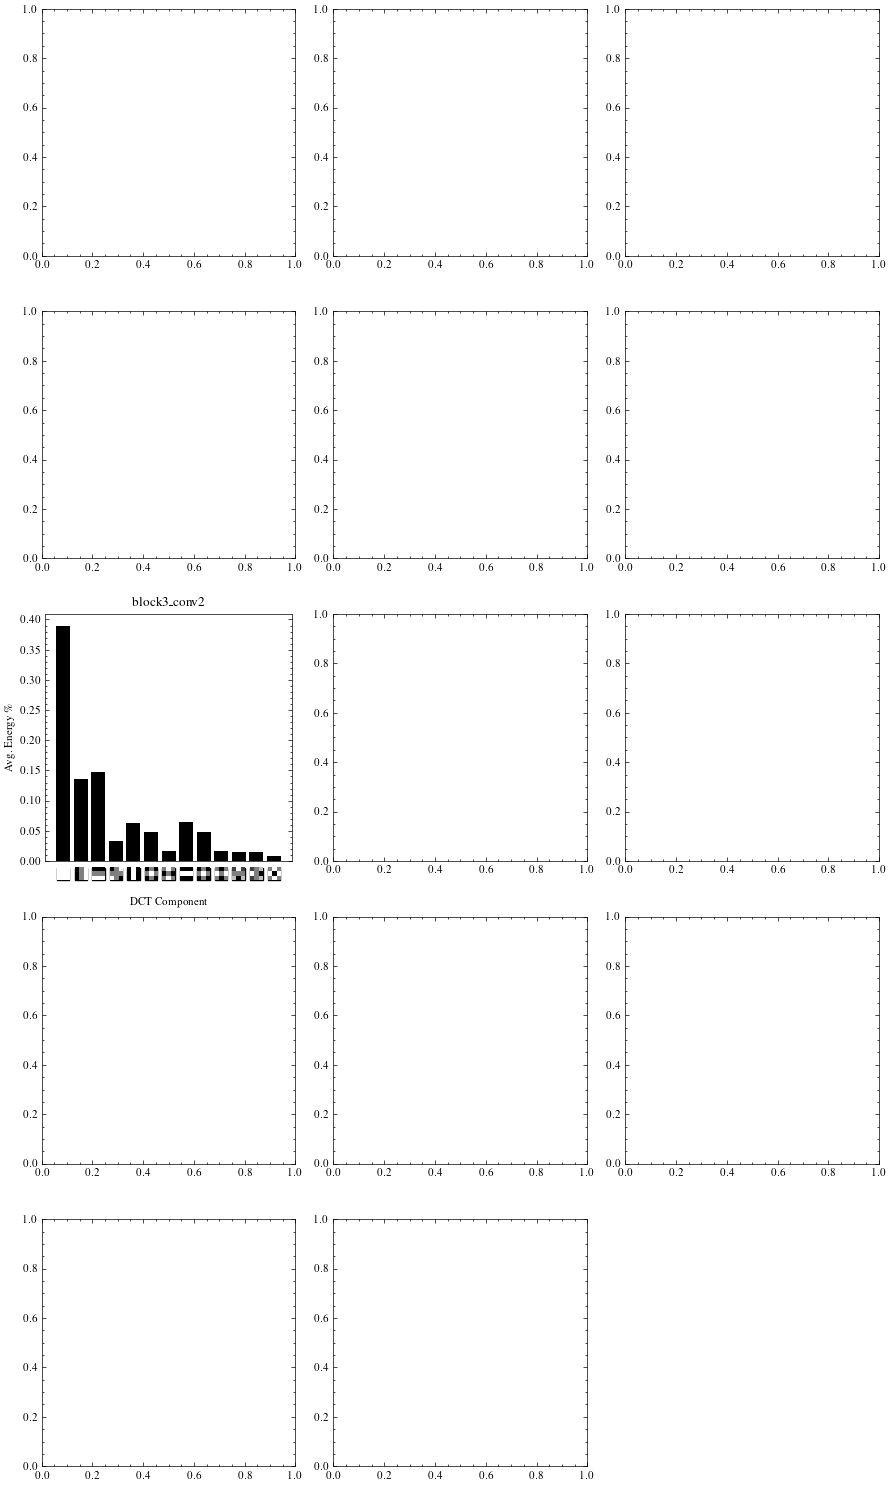

In [16]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


#bars =  ax.bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], vals)
pos = [(0,0) , (0,1), (1,0), (1,1), (0, 2) , (2, 0), (1,2), (2,1), (2,2) ]

d = []
for  i,j in pos:
	t = np.zeros((3,3))
	t[i,j] =1
	d.append(tf.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)))
	s, a = getSymAntiSymTF(d[-1].numpy().round(7))
	if reduce_euclidean_norm(s) > 0. and reduce_euclidean_norm(a) > 0. :
		d.append(s)
		d.append(a)

d = tf.cast(tf.stack(d), dtype=tf.float32)

fig,axs= plt.subplots(nrows=5, ncols=3,figsize=(9, 15))
axs = axs.ravel()
print(d.shape)

for l_num in range(5, 6):  #
	
	if l_num == -1:
		f = np.random.normal(0,1, size=(3,3,50,50))
		title = "Random"
	else:
		f = get_filter(model, l_num)
		title = conv_layers[l_num].name
	w = tf.reshape(tf.reduce_sum(f*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
	print(w.shape)
	bars =  axs[l_num+1].bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10", "c11", "c12"], tf.reduce_sum(w**2, axis=(1,2,3,4))/tf.math.reduce_sum(w**2))


	for i, bar in enumerate(bars):
		# Load image

		#dct_im = np.zeros((3,3))
		#dct_im[pos[i]]=1
		#print(idct2(np.float16(dct_im)))
		#img = idct2(np.float16(dct_im))
		img = d[i, :,:, 0,0]

		# Create OffsetImage object
		im = OffsetImage(img, zoom=3, cmap=plt.cm.binary)  # Adjust zoom for image size

		# Get the x position of the bar's center
		x_position = bar.get_x() + bar.get_width() / 2

		# Place image below the x-axis label
		ab = AnnotationBbox(im, (x_position, 0), 
							xybox=(0, -5),  # Adjust the second value for distance under the label
							xycoords='data', 
							boxcoords="offset points", 
							pad=0, frameon=True, 
							box_alignment=(0.5, 1))

		# Add image to the axes
		axs[l_num+1].add_artist(ab)
	axs[l_num+1].set_xticklabels([''] * w.shape[0])  # Set empty labels
	axs[l_num+1].set_xlabel('DCT Component')
	axs[l_num+1].xaxis.set_label_coords(0.5, -0.15)
	axs[l_num+1].set_ylabel('Avg. Energy \%')
	axs[l_num+1].set_box_aspect(1)
	axs[l_num+1].set_title(title)


	axs[l_num+1].tick_params(axis='x', which='both', length=0)
axs[-1].set_box_aspect(1)

fig.delaxes(axs[-1])

fig.tight_layout()
plt.savefig('figures/vgg16_dct_further.pdf', dpi=600)

plt.show()

In [30]:
dct2(np.float16(d[8, :,:,0,0]))

array([[0.0000000e+00, 0.0000000e+00, 5.0003290e-01],
       [2.5809570e-08, 0.0000000e+00, 0.0000000e+00],
       [5.0003296e-01, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
w.shape

TensorShape([9, 1, 1, 512, 512])

[[1.         0.19702518]
 [0.19702518 1.        ]]


LinregressResult(slope=0.1151407201785406, intercept=0.004575393975873878, rvalue=0.19702517679222312, pvalue=0.0, stderr=0.0022380845229123254, intercept_stderr=3.280758250419563e-05)

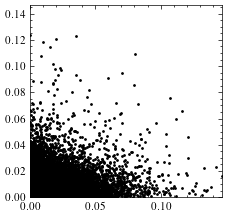

In [20]:
from scipy.stats import linregress

wx = tf.abs(tf.reshape(w[1], (-1))).numpy()
wx2 =tf.abs(tf.reshape(w[5], (-1))).numpy()



lim_x = np.max(np.abs(wx))
lim_y = np.max(np.abs(wx2))
lim = np.max([lim_x, lim_y])
lim*= 0.5
plt.scatter(wx,wx2, s=1);
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.gca().set_aspect('equal')
print(np.corrcoef(wx, wx2))
linregress(wx, wx2)


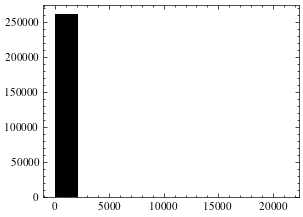

In [ ]:
plt.hist(wx2/wx, bins=10);

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        6.00000e+00, 9.00000e+01, 2.91820e+04, 2.32778e+05, 8.70000e+01]),
 array([-0.21337596, -0.18726864, -0.16116133, -0.13505402, -0.1089467 ,
        -0.08283939, -0.05673208, -0.03062477, -0.00451745,  0.02158986,
         0.04769717], dtype=float32),
 <BarContainer object of 10 artists>)

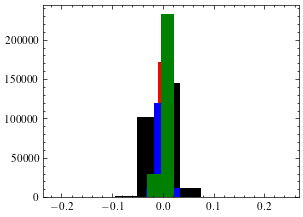

In [ ]:
plt.hist(tf.reshape(w[0], (-1)).numpy())
plt.hist(tf.reshape(w[1], (-1)).numpy())
plt.hist(tf.reshape(w[2], (-1)).numpy())
plt.hist(tf.reshape(w[4], (-1)).numpy())

In [ ]:
np.var(tf.reshape(w[4], (-1)).numpy())

2.1165999e-05

In [ ]:
np.rot90([[0,1,0],
          [1,0,-1],
          [0,-1,0]])

array([[ 0, -1,  0],
       [ 1,  0, -1],
       [ 0,  1,  0]])

In [ ]:
np.rot90([[1,0,-1],
          [0,0,0],
          [1,0,-1]])

array([[-1,  0, -1],
       [ 0,  0,  0],
       [ 1,  0,  1]])

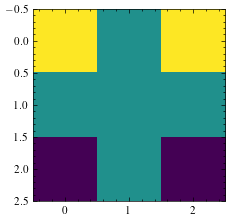

In [ ]:
plt.imshow(d[1, :,:,0,0] * d[3, :,:,0,0] )

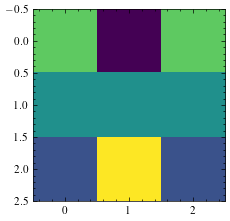

In [ ]:
plt.imshow(d[6, :,:,0,0] )

In [ ]:
(1/np.sqrt(2))*(d[1, :,:,0,0] * d[2, :,:,0,0])/2, d[3, :,:,0,0]

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[ 5.8925565e-02, -8.0123444e-18, -5.8925565e-02],
        [-1.1331166e-17,  1.5407439e-33,  1.1331166e-17],
        [-5.8925565e-02,  8.0123444e-18,  5.8925565e-02]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[ 5.0000000e-01, -2.7755576e-17, -5.0000000e-01],
        [-9.6148133e-17,  1.8488927e-32,  9.6148133e-17],
        [-5.0000000e-01,  8.3266727e-17,  5.0000000e-01]], dtype=float32)>)